<h1><center>ASHRAE - Great Energy Predictor III -  Modeling💡</center></h1>

# Libraries 📚

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import gc

In [3]:
#modeling
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import lightgbm as lgb
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


/Users/vaishali/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


# Read data from interim files

In [5]:
is_colab = False

In [6]:
if is_colab:
  from google.colab import drive
  from pathlib import Path
  drive.mount("/content/drive", force_remount=True)
  #base = Path('/content/drive/My Drive/Capstone2/Ashrae')
  #import sys
  #sys.path.append(str(base))
  import os
  os.chdir('/content/drive/MyDrive/Capstone2/Ashrae')

In [7]:
if is_colab:
  !pip install pickle5
  import pickle5 as pickle
  train_df = pickle.load(open('data/train_df.pickle','rb'))
  test_df = pickle.load(open('data/test_df.pickle','rb'))
  building_metadata_df = pickle.load(open('data/building_metadata_df.pickle','rb'))
  weather_train_df = pickle.load(open('data/weather_train_df.pickle','rb'))
  weather_test_df = pickle.load(open('data/weather_test_df.pickle','rb'))
else:
  train_df = pd.read_pickle("../data/interim/post_featureEng/train_df.pickle")
  test_df = pd.read_pickle("../data/interim/post_featureEng/test_df.pickle")
  building_metadata_df = pd.read_pickle("../data/interim/post_featureEng/building_metadata_df.pickle")
  weather_train_df = pd.read_pickle("../data/interim/post_featureEng/weather_train_df.pickle")
  weather_test_df = pd.read_pickle("../data/interim/post_featureEng/weather_test_df.pickle")

In [8]:
test_df.drop(columns='row_id',inplace=True)

In [9]:
train_df.reset_index(inplace=True)

In [77]:
weather_train_df.drop(columns='index',inplace=True)

### Reduce Memory

In [10]:
def reduce_mem_df(df):
    df_mem_before = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(df_mem_before))
    
    for col in df.columns:
        if df[col].dtype == 'datetime64' or pd.api.types.is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == "float":
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    df_mem_after = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(df_mem_after))
    print("Decreased by {:.1f}%".format(100 * (df_mem_before - df_mem_after) / df_mem_before))
    
    return df

In [11]:
test_df = reduce_mem_df(test_df)

Memory usage of dataframe is 1391.81 MB
Memory usage after optimization is: 1232.74 MB
Decreased by 11.4%


In [12]:
#For LGBM Categorical data needs to be converted to int values
test_df['meter_type'] = test_df['meter_type'].astype(np.int8)
train_df['meter_type'] = train_df['meter_type'].astype(np.int8)

In [13]:
weather_train_df = reduce_mem_df(weather_train_df)

Memory usage of dataframe is 26.40 MB
Memory usage after optimization is: 16.62 MB
Decreased by 37.1%


In [14]:
weather_test_df = reduce_mem_df(weather_test_df)

Memory usage of dataframe is 50.53 MB
Memory usage after optimization is: 32.08 MB
Decreased by 36.5%


In [15]:
weather_train_df.drop(columns='time',inplace=True)
weather_test_df.drop(columns='time',inplace=True)

## Feature engineering

In [16]:
#Could have a used a label encoder here.
primary_use_list = building_metadata_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_metadata_df['primary_use'] = building_metadata_df['primary_use'].map(primary_use_dict)
gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


58

In [17]:
building_metadata_df['primary_use'] = building_metadata_df['primary_use'].astype(np.int8)

In [18]:
weather_train_df['week'] = weather_train_df['week'].astype(np.int8)

In [19]:
category_cols = ["site_id","building_id","meter_type","primary_use", "hour","week","day_of_week","month","day_of_year"]

In [143]:
feature_cols = list(set(list(train_df.columns) + list(building_metadata_df.columns) + list(weather_train_df.columns))\
               - set(category_cols + list(['meter_reading_log1p','meter_reading','timestamp'])))

In [144]:
feature_cols

['floor_count',
 'wind_direction_shift2',
 'meter_build_min',
 'sea_level_pressure_shift2',
 'dew_temperature',
 'dew_temperature_rollmean_6',
 'cloud_coverage_rollmean_6',
 'air_temperature',
 'precip_depth_1_hr_rollmean_6',
 'meter_build_median',
 'wind_speed_shift1',
 'cloud_coverage_shift1',
 'wind_direction',
 'meter_build_max',
 'wind_direction_rollmean_6',
 'meter_build_std',
 'square_feet',
 'air_temperature_rollmean_6',
 'air_temperature_shift2',
 'air_temperature_shift1',
 'meter_reading_log1p_rollmean_6',
 'precip_depth_1_hr_shift1',
 'wind_speed_rollmean_6',
 'sea_level_pressure_rollmean_6',
 'wind_speed',
 'dew_temperature_shift1',
 'sea_level_pressure_shift1',
 'wind_direction_shift1',
 'year_built',
 'precip_depth_1_hr',
 'cloud_coverage',
 'sea_level_pressure',
 'wind_speed_shift2',
 'meter_build_mean']

# Merge dfs

In [21]:
def merge_dfs(meter_df,weather_df):
    merged_meter_df = meter_df.merge(building_metadata_df, on=['building_id'],how='left')
    merged_meter_df = merged_meter_df.merge(weather_df, on=['site_id', 'timestamp'], how='left')
    return merged_meter_df

In [78]:
merged_meter_df = merge_dfs(train_df,weather_train_df)

In [172]:
def create_X_y(merged_meter_df,feature_cols,category_cols,target_meter=None,drop_cols=[]):
    if target_meter is not None:
      merged_meter_df = merged_meter_df[merged_meter_df.meter_type==target_meter]
    X = merged_meter_df[list(set(feature_cols + category_cols) - set(drop_cols))]
    y = merged_meter_df['meter_reading_log1p'].values

    del merged_meter_df
    return X,y

# Create a holdout dataset 
*To be used as Test set to make predictions and compare models based on those.*

In [79]:
percent_80 = int(len(merged_meter_df)*0.8)
merged_train_df = merged_meter_df[:percent_80]
merged_test_df = merged_meter_df[percent_80:]
del merged_meter_df

### Define a df for comparing models

In [80]:
model_compare_df = pd.DataFrame(columns=['model_name','meter_type','mse_train','mse_test','R2-train','R2-test'])
#R2 - total variance explained by model

# Feature selection using sklearn

In [26]:
corr = merged_train_df.corr()
corr = pd.DataFrame(np.triu(corr.to_numpy(),1),index=corr.index,columns=corr.index).stack()

In [88]:
correlated_cols = list(set(['month','week','dew_temperature','site_id'] + \
                           list(merged_train_df.columns[merged_train_df.columns.str.match('(meter_build)|(.*rollmean*)|(.*shift*)')])) \
                       - set(['meter_build_mean']))

In [82]:
correlated_cols

['air_temperature_rollmean_6',
 'air_temperature_shift2',
 'air_temperature_shift1',
 'meter_reading_log1p_rollmean_6',
 'precip_depth_1_hr_shift1',
 'wind_direction_shift2',
 'meter_build_min',
 'wind_speed_rollmean_6',
 'sea_level_pressure_shift2',
 'dew_temperature',
 'dew_temperature_rollmean_6',
 'site_id',
 'sea_level_pressure_rollmean_6',
 'cloud_coverage_rollmean_6',
 'dew_temperature_shift1',
 'precip_depth_1_hr_rollmean_6',
 'sea_level_pressure_shift1',
 'week',
 'meter_build_median',
 'wind_speed_shift1',
 'cloud_coverage_shift1',
 'meter_build_max',
 'wind_direction_shift1',
 'wind_direction_rollmean_6',
 'meter_build_std',
 'month',
 'wind_speed_shift2']

# Linear model analysis

### Linear regression

In [83]:
def one_hot_encode(X):
  ohe = OneHotEncoder(drop='first')
  _df = pd.DataFrame(ohe.fit_transform(X[['primary_use']]).toarray())
  _df.columns = ohe.get_feature_names(['primary_use'])
  X = X.join(_df)
  del _df
  gc.collect()
  return X

In [84]:
#X = one_hot_encode(X) - Making the df size very large. 

In [89]:
def model_predict(model,model_name,X_train,y_train,X_test,y_test,is_LR=True):
  y_train_pred = model.predict(X_train)
  lr_mse_train = mean_squared_error(y_train,y_train_pred)
  lr_r2_train = r2_score(y_train,y_train_pred)

  
  y_test_pred = model.predict(X_test)
  lr_mse_test = mean_squared_error(y_test,y_test_pred)
  lr_r2_test = r2_score(y_test,y_test_pred)

  residuals_test = pd.DataFrame({"true":y_test, "residuals":y_test - y_test_pred})
  model_compare_df.loc[len(model_compare_df.index)] = [model_name,target_meter,lr_mse_train,lr_mse_test,lr_r2_train,lr_r2_test]

  if (is_LR==True):
    fig,axes = plt.subplots(1,3,figsize=(15,3))
    residuals_test.plot(x='true',y='residuals',kind='scatter',title='meter_'+ str(target_meter),ax=axes[0])
    coef = pd.Series(model['model'].coef_,X_train.columns).sort_values()
    coef.plot(kind='bar',title='model coefficients',ax=axes[1])
    #Testing Homoscedasticity (constant variance): The variance of the errors is constant with respect to the predicting variables or the response.

    sm.qqplot(residuals_test['residuals'],ax=axes[2])
    #Normality: The errors are generated from a Normal distribution (of unknown mean and variance, which can be estimated from the data).
  #https://www.analyticsvidhya.com/blog/2013/12/residual-plots-regression-model/


CPU times: user 22.1 s, sys: 7.5 s, total: 29.6 s
Wall time: 12.8 s


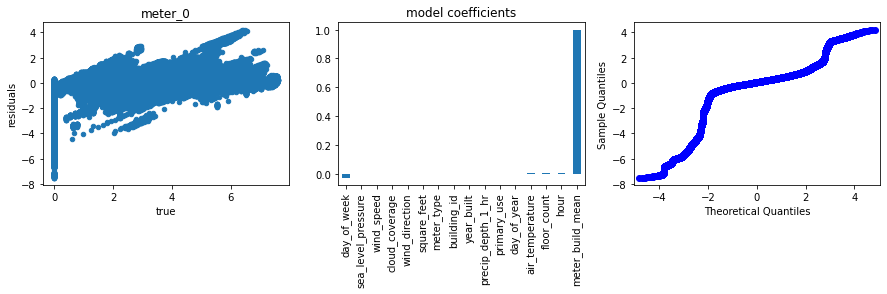

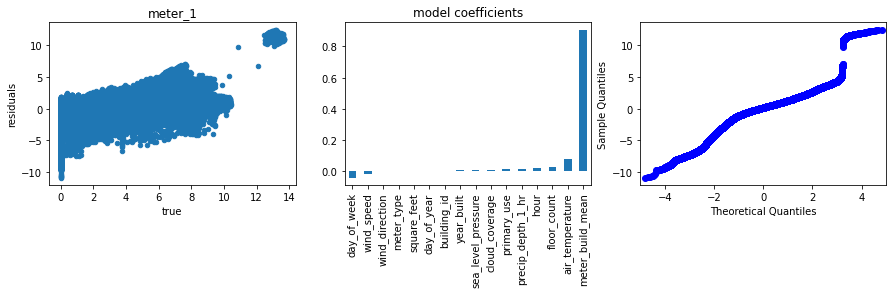

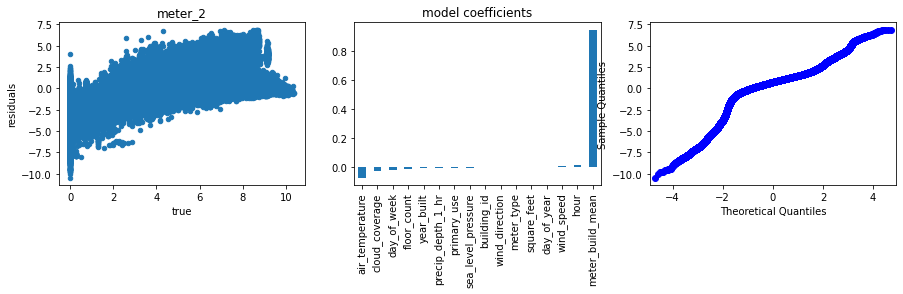

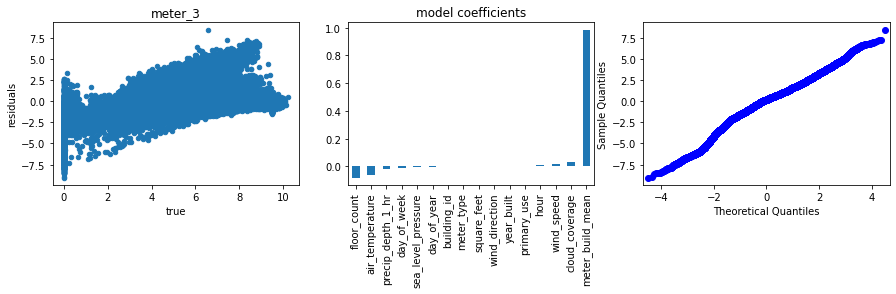

In [90]:
%%time
from sklearn.pipeline import Pipeline
drop_cols = correlated_cols
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,drop_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,drop_cols)
  model_lr = Pipeline([('model',LinearRegression())])
  model_lr.fit(X_train,y_train)
  
  model_predict(model_lr,'Linear Regression',X_train,y_train,X_test,y_test)

The graphs above show that the residual plots show hetroscedacity (changing variance in residuals)
To remove hetroscedacity is it suggested to weighted least squares(But this would mean to assign individual weights to all records)

The q-q plot shows that the errors are not normally distributed , which means we need to try non-linear transformation

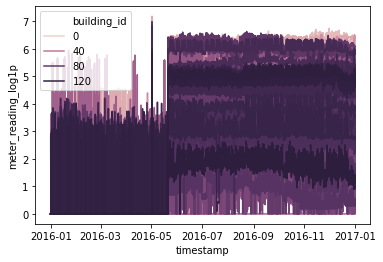

In [51]:
sns.lineplot(x = 'timestamp',y='meter_reading_log1p',data = train_df[(train_df.meter_type==0) & (train_df.building_id < 100)],hue = 'building_id')

<Figure size 1800x1440 with 0 Axes>

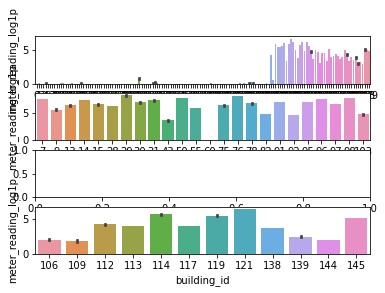

In [69]:
plt.figure(figsize=(25, 20))
fig,axes = plt.subplots(4,1)
for i in range(4):
    try:
        sns.barplot(x='building_id',y='meter_reading_log1p',data=train_df[(train_df.meter_type==i) & (train_df.timestamp < '2016-05') \
                                                                  & (train_df.building_id < 150)],ax=axes[i])
    except ValueError:
        pass

## We will standardize the data as that is what linear regression prefers.

In [91]:
from sklearn.pipeline import make_pipeline

CPU times: user 25.8 s, sys: 9.51 s, total: 35.3 s
Wall time: 16.3 s


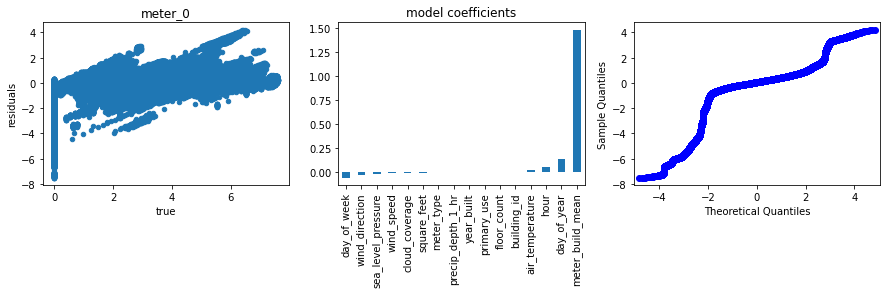

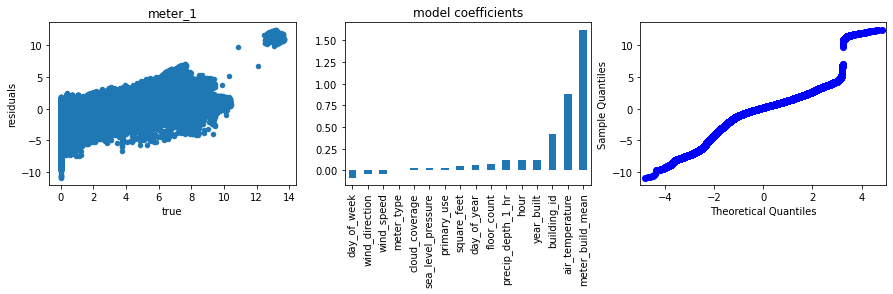

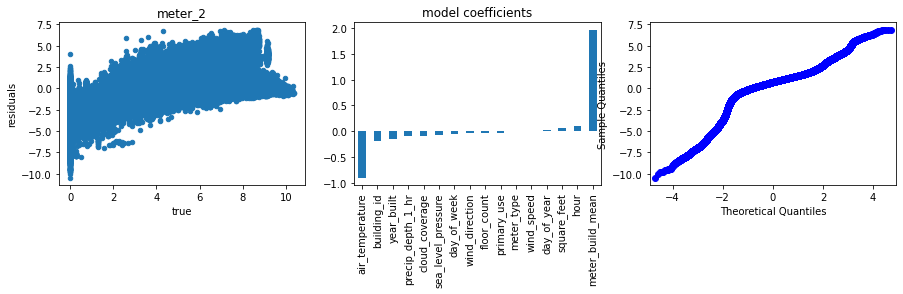

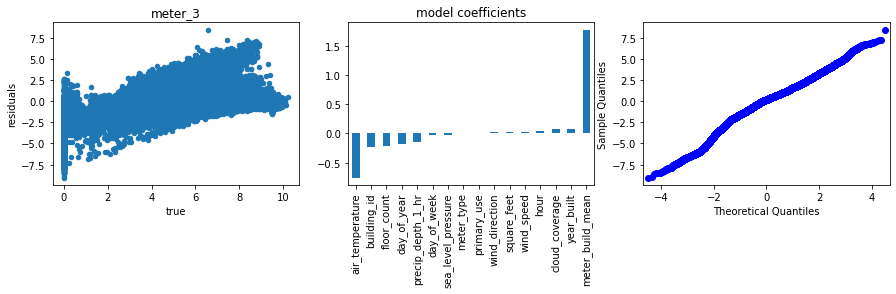

In [92]:
%%time
from sklearn.pipeline import make_pipeline
drop_cols = correlated_cols
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,drop_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,drop_cols)
  model_ss_lr = Pipeline([('scaler',StandardScaler()),('model',LinearRegression())])
  model_ss_lr.fit(X_train,y_train)
  model_predict(model_ss_lr,'Linear regression with Standard Scaler',X_train,y_train,X_test,y_test)

## Ridge regression

CPU times: user 18.1 s, sys: 8.15 s, total: 26.3 s
Wall time: 13.5 s


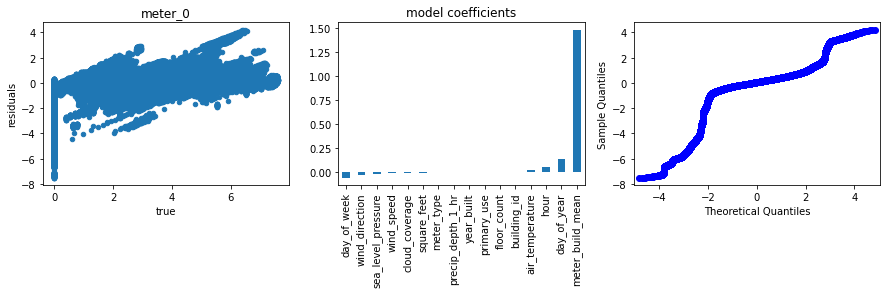

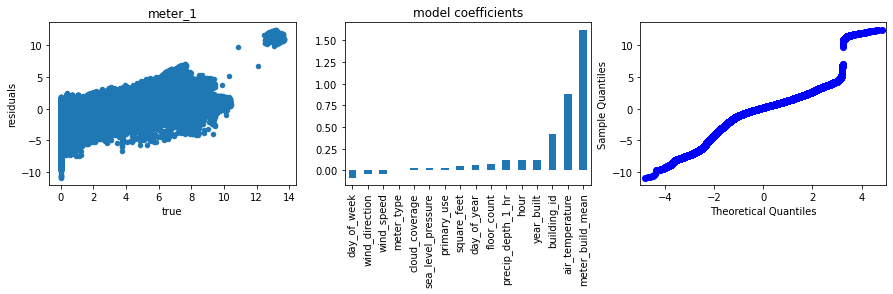

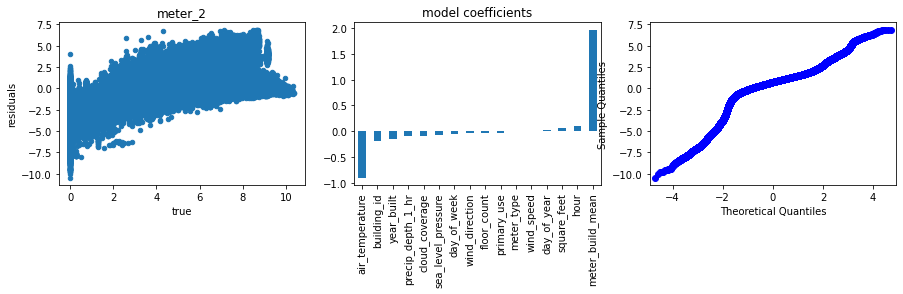

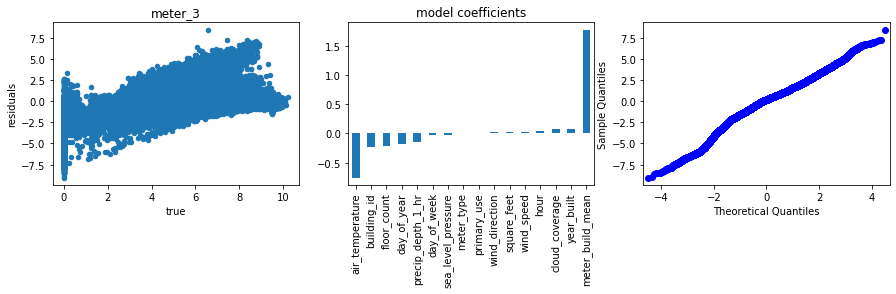

In [94]:
%%time
from sklearn import linear_model
from sklearn.pipeline import Pipeline
drop_cols = correlated_cols
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,drop_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,drop_cols)
  #lr_ridge = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
  lr_ridge = Pipeline([('scaler',StandardScaler()),('model',linear_model.Ridge(alpha=.5))])
  lr_ridge.fit(X_train,y_train)
  model_predict(lr_ridge,'Linear regression with Ridge',X_train,y_train,X_test,y_test)

# SGD analysis

CPU times: user 35 s, sys: 8.55 s, total: 43.6 s
Wall time: 37.7 s


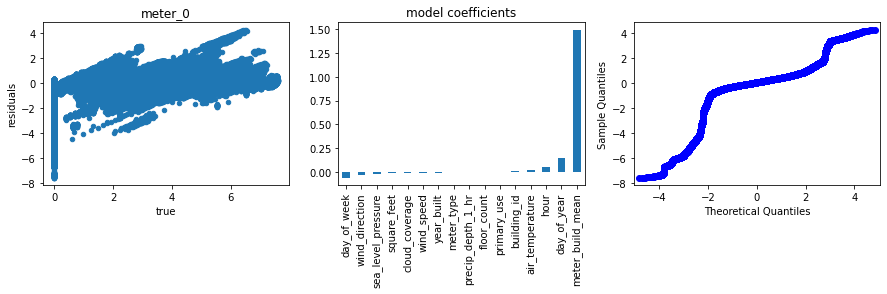

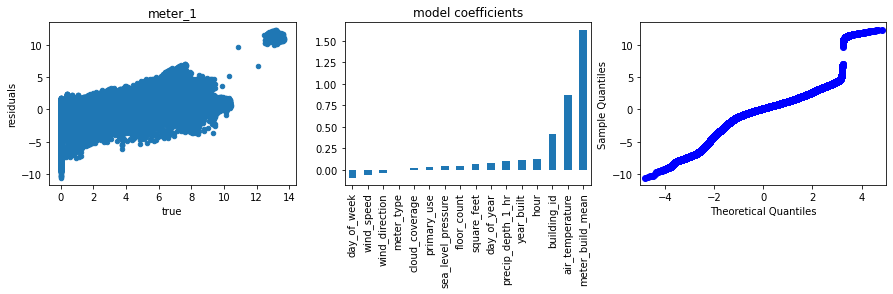

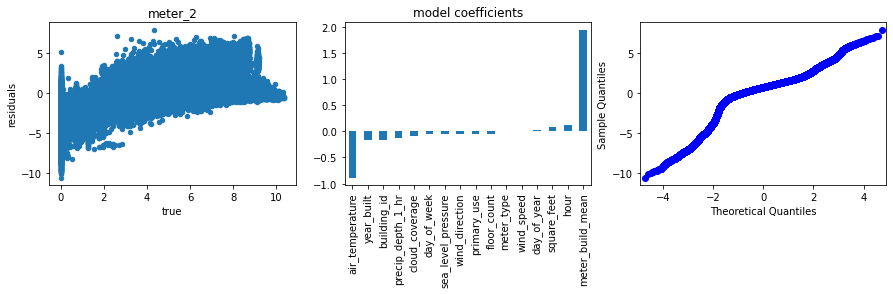

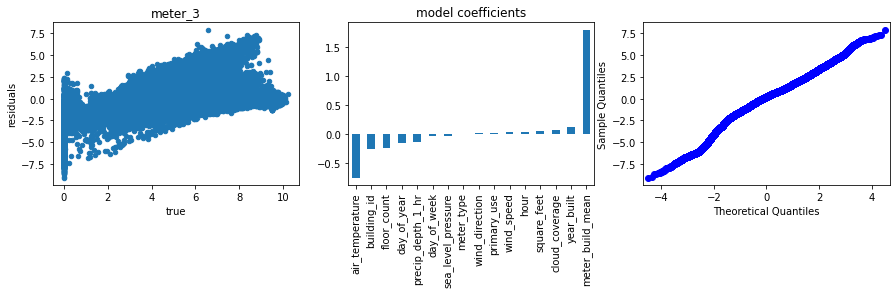

In [96]:
%%time
from sklearn.linear_model import SGDRegressor

drop_cols = correlated_cols
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,drop_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,drop_cols)
  sgd_model = Pipeline([('scaler',StandardScaler()),('model',SGDRegressor())])
  sgd_model.fit(X_train,y_train)
  model_predict(sgd_model,'SGD with standard scaler',X_train,y_train,X_test,y_test)

# RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
'''
%%time
from sklearn.ensemble import RandomForestRegressor
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,correlated_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,correlated_cols)
  #param_grid = {'n_estimators':np.arange(10,100)}
  rfc = Pipeline([('model',RandomForestRegressor(n_estimators=10))])
  #rfc_cv= GridSearchCV(rfc,param_grid,cv=5)
  rfc.fit(X_train,y_train)
  model_predict(rfc,'RFC',X_train,y_train,X_test,y_test,False)
'''

"\n%%time\nfrom sklearn.ensemble import RandomForestRegressor\nfor target_meter in range(4):\n  X_train,y_train = create_X_y(merged_train_df,target_meter,correlated_cols)\n  X_test,y_test = create_X_y(merged_test_df,target_meter,correlated_cols)\n  #param_grid = {'n_estimators':np.arange(10,100)}\n  rfc = Pipeline([('model',RandomForestRegressor(n_estimators=10))])\n  #rfc_cv= GridSearchCV(rfc,param_grid,cv=5)\n  rfc.fit(X_train,y_train)\n  model_predict(rfc,'RFC',X_train,y_train,X_test,y_test,False)\n"

In [ ]:
'''
%%time
from sklearn.ensemble import RandomForestRegressor
target_meter = 0
X_train,y_train = create_X_y(merged_train_df,target_meter,correlated_cols)
X_test,y_test = create_X_y(merged_test_df,target_meter,correlated_cols)
#param_grid = {'n_estimators':np.arange(10,100)}
rfc_ss = Pipeline([('scaler',StandardScaler()),('model',RandomForestRegressor(n_estimators=10))])
#rfc_cv= GridSearchCV(rfc,param_grid,cv=5)
rfc.fit(X_train,y_train)

model_predict(rfc,'RFC',X_train,y_train,X_test,y_test,False)
'''

"\n%%time\nfrom sklearn.ensemble import RandomForestRegressor\ntarget_meter = 0\nX_train,y_train = create_X_y(merged_train_df,target_meter,correlated_cols)\nX_test,y_test = create_X_y(merged_test_df,target_meter,correlated_cols)\n#param_grid = {'n_estimators':np.arange(10,100)}\nrfc_ss = Pipeline([('scaler',StandardScaler()),('model',RandomForestRegressor(n_estimators=10))])\n#rfc_cv= GridSearchCV(rfc,param_grid,cv=5)\nrfc.fit(X_train,y_train)\n\nmodel_predict(rfc,'RFC',X_train,y_train,X_test,y_test,False)\n"

### LGBMRegressor

In [97]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [98]:
%%time
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter)
  X_test,y_test = create_X_y(merged_test_df,target_meter)

  gbm = LGBMRegressor()
  model_lgb = gbm.fit(X_train,y_train,categorical_feature=category_cols)
  model_predict(model_lgb,'LGBM',X_train,y_train,X_test,y_test,False)

/Users/vaishali/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'day_of_week', 'day_of_year', 'hour', 'meter_type', 'month', 'primary_use', 'site_id', 'week']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/vaishali/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'day_of_week', 'day_of_year', 'hour', 'meter_type', 'month', 'primary_use', 'site_id', 'week']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/vaishali/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'day_of_week', 'day_of_year', 'hour', 'meter_type', 'month', 'primary_use', 'site_id', 'week']
  warnings.warn('categorical_fe

CPU times: user 13min 54s, sys: 44.4 s, total: 14min 39s
Wall time: 2min 33s


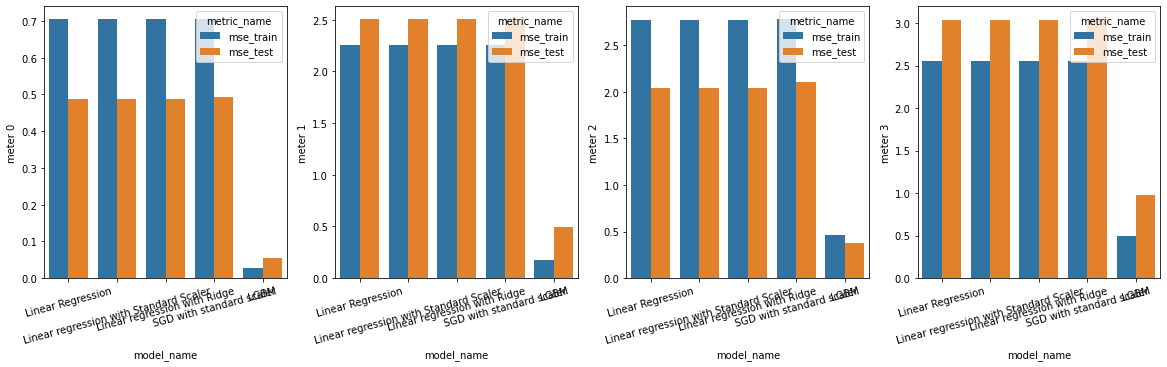

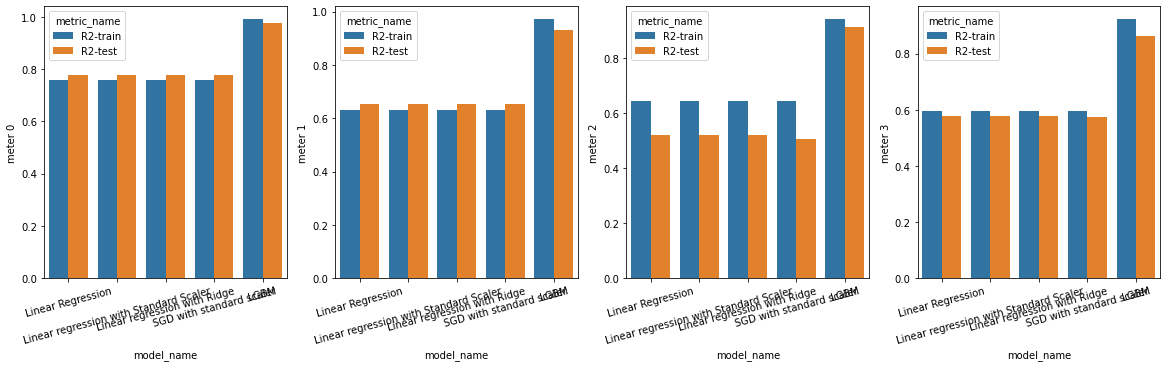

In [99]:
fig,axes = plt.subplots(1,4,figsize=(20,5))
for i in range(4): 
  axs = axes.ravel()[i]
  sns.barplot(x='model_name',y='metric_value',hue='metric_name',\
            data=model_compare_df[model_compare_df.meter_type==i].melt(id_vars=['model_name'],\
            value_vars=['mse_train', 'mse_test'],\
            var_name='metric_name',value_name = 'metric_value'),ax=axs)
  axs.set_xticklabels(labels = model_compare_df.model_name.unique(),rotation=15)
  axs.set_ylabel('meter ' + str(i))

fig,axes = plt.subplots(1,4,figsize=(20,5))
for i in range(4): 
  axs = axes.ravel()[i]
  sns.barplot(x='model_name',y='metric_value',hue='metric_name',\
            data=model_compare_df[model_compare_df.meter_type==i].melt(id_vars=['model_name'],\
            value_vars=['R2-train','R2-test'],\
            var_name='metric_name',value_name = 'metric_value'),ax=axs)
  axs.set_xticklabels(labels = model_compare_df.model_name.unique(),rotation=15)
  axs.set_ylabel('meter ' + str(i))
  

LGBM seems to be performing best when it comes to R2 metric and also has the least mse_train.

In [114]:
model_compare_df

,model_name,meter_type,mse_train,mse_test,R2-train,R2-test
0,Linear Regression,0,0.703912,0.488190,0.758801,0.778717
1,Linear Regression,1,2.256075,2.504188,0.631126,0.651957
2,Linear Regression,2,2.774143,2.041620,0.642776,0.517962
3,Linear Regression,3,2.550813,3.036178,0.595687,0.576152
4,Linear regression with Standard Scaler,0,0.703912,0.488190,0.758801,0.778717
5,Linear regression with Standard Scaler,1,2.256075,2.504188,0.631126,0.651957
6,Linear regression with Standard Scaler,2,2.774143,2.041620,0.642776,0.517962
7,Linear regression with Standard Scaler,3,2.550813,3.036178,0.595687,0.576152
8,Linear regression with Ridge,0,0.703912,0.488190,0.758801,0.778717
9,Linear regression with Ridge,1,2.256075,2.504188,0.631126,0.651957


### Compare various lgbm models

In [102]:
gbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [103]:
lgbm_compare_df = pd.DataFrame(columns=['lgbm_name','target_meter','mse_train','mse_test','R2-train','R2-test','parameters'])

In [140]:
def lgbm_predict(model,lgbm_name,X_train,y_train,X_test,y_test,target_meter):
  y_train_pred = model.predict(X_train)
  lr_mse_train = mean_squared_error(y_train,y_train_pred)
  lr_r2_train = r2_score(y_train,y_train_pred)

  
  y_test_pred = model.predict(X_test)
  lr_mse_test = mean_squared_error(y_test,y_test_pred)
  lr_r2_test = r2_score(y_test,y_test_pred)

  residuals_test = pd.DataFrame({"true":y_test, "residuals":y_test - y_test_pred})
  lgbm_compare_df.loc[len(lgbm_compare_df.index)] = [lgbm_name,target_meter,lr_mse_train,lr_mse_test,lr_r2_train,lr_r2_test,model.best_params_]

#### LGBM with GridSearch CV

In [109]:
%%time
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter)
  X_test,y_test = create_X_y(merged_test_df,target_meter)

  param_dist = {"max_depth": [10,50],
              "learning_rate" : [0.05,0.1],
              "num_leaves": [31,100],
              "n_estimators": [10,100,150],
              }
  lgbm_grid_1 = GridSearchCV(gbm, param_grid=param_dist,cv = 5, scoring="neg_mean_squared_error", verbose=5)
  lgbm_grid_1.fit(X_train,y_train)
  lgbm_predict(lgbm_grid_1,'LGBM_gridsearchCV_1',X_train,y_train,X_test,y_test,target_meter)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-1.518, total=  27.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.7s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-0.682, total=  20.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.2s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-1.142, total=  17.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-1.301, total=  17.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-0.915, total=  18.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-1.509, total=  24.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-0.680, total=  24.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-1.140, total=  22.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-1.293, total=  21.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-0.910, total=  21.2s
[CV] learning_rate=0.05, max_depth=

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 156.4min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-1.631, total=   6.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-2.434, total=   5.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-1.891, total=   4.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.0s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-3.749, total=   4.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.4s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-3.072, total=   4.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-1.623, total=   5.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-2.417, total=   5.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-1.889, total=   5.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-3.713, total=   5.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-3.045, total=   5.1s
[CV] learning_rate=0.05, max_depth=

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 32.2min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-3.604, total=   3.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-2.480, total=   3.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-2.522, total=   3.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-5.090, total=   3.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.3s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-3.661, total=   3.2s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-3.602, total=   3.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-2.451, total=   3.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-2.506, total=   3.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-5.070, total=   3.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-3.658, total=   3.5s
[CV] learning_rate=0.05, max_depth=

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 75.5min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-2.368, total=   1.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-1.576, total=   1.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-2.121, total=   1.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-3.993, total=   1.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.1s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-4.320, total=   1.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-2.370, total=   1.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-1.575, total= 5.0min
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-2.116, total=   1.7s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-3.964, total=   1.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-4.325, total=   1.6s
[CV] learning_rate=0.05, max_depth=

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 66.6min finished


CPU times: user 19h 14min 4s, sys: 1h 8min 48s, total: 20h 22min 53s
Wall time: 5h 34min 29s


In [110]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

#### LGBM with GridSearch and TimeSeries fold CV

In [111]:
%%time
from sklearn.model_selection import TimeSeriesSplit
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter)
  X_test,y_test = create_X_y(merged_test_df,target_meter)

  param_dist = {"max_depth": [10,50],
              "learning_rate" : [0.05,0.1],
              "num_leaves": [31,100],
              "n_estimators": [150],
              }
  tscv = TimeSeriesSplit(n_splits=3)
  lgbm_grid_1 = GridSearchCV(gbm, param_grid=param_dist,cv = tscv, scoring="neg_mean_squared_error", verbose=5)
  lgbm_grid_1.fit(X_train,y_train)
  lgbm_predict(lgbm_grid_1,'LGBM_GS_TimeSeriesSplit',X_train,y_train,X_test,y_test,target_meter)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-0.811, total=  11.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-1.351, total=  15.9s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.6s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-0.958, total=  23.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.6s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-0.822, total=   7.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   57.6s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-1.347, total=  11.9s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-0.954, total=  22.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-0.039, total=  23.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-0.074, total=  40.7s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-0.058, total= 1.1min
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=100, score=-0.055, total=  28.4s
[CV] learning_rate=0.05, max_dep

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 52.5min finished


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-2.096, total=   2.2s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-2.947, total=   3.2s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-3.125, total=   4.7s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-2.075, total=   2.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.1s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-2.926, total=   3.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-3.094, total=   4.7s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-0.242, total=   5.9s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-0.279, total=  11.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-0.480, total=  16.2s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=100, score=-0.255, total=   7.6s
[CV] learning_rate=0.05, max_dep

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 13.0min finished


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-1.755, total=   1.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-5.074, total=   2.2s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-4.111, total=   3.2s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-1.743, total=   1.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.1s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-5.022, total=   2.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-4.104, total=   3.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-0.622, total=   4.7s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-1.056, total=   8.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-0.665, total=  12.7s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=100, score=-0.615, total=   6.5s
[CV] learning_rate=0.05, max_dep

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  9.5min finished


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-1.489, total=   0.7s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-3.763, total=   1.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-4.371, total=   1.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-1.484, total=   0.7s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.9s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-3.736, total=   1.2s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100, score=-4.369, total=   1.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-0.186, total=   2.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-0.940, total=   4.2s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=31, score=-1.255, total=   6.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=100 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=100, score=-0.182, total=   3.5s
[CV] learning_rate=0.05, max_dep

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  4.6min finished


CPU times: user 8h 2min 4s, sys: 27min 36s, total: 8h 29min 40s
Wall time: 1h 24min 43s


In [112]:
lgbm_compare_df

,lgbm_name,target_meter,mse_train,mse_test,R2-train,R2-test,parameters
0,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",0,0.039756,0.055438,0.986377,0.974872,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
1,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",1,0.155925,0.432524,0.974506,0.939886,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
2,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",2,0.489478,0.395259,0.936970,0.906677,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
3,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",3,0.532634,1.146853,0.915576,0.839900,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es..."
4,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,0,0.039756,0.055438,0.986377,0.974872,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
5,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,1,0.180276,0.419941,0.970524,0.941635,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
6,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,2,0.491872,0.399797,0.936662,0.905606,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
7,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,3,0.521343,1.215322,0.917365,0.830342,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."


In [122]:
%%time
drop_cols = 'meter_reading_log1p_rollmean_6'
gbm = LGBMRegressor()
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,drop_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,drop_cols)

  param_dist = {"max_depth": [50],
              "learning_rate" : [0.1],
              "num_leaves": [31],
              "n_estimators": [100],
              }
  tscv = TimeSeriesSplit(n_splits=3)
  lgbm_grid_3 = GridSearchCV(gbm, param_grid=param_dist,cv = tscv, scoring="neg_mean_squared_error", verbose=5)
  lgbm_grid_3.fit(X_train,y_train)
  lgbm_predict(lgbm_grid_3,'LGBM_GS_TimeSeriesSplit_without_rollmean',X_train,y_train,X_test,y_test,target_meter)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.040, total=  23.8s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.073, total=  40.5s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.056, total= 1.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.242, total=   5.7s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.263, total=  10.4s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.478, total=  15.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.620, total=   3.8s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-1.031, total=   6.6s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.686, total=   9.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.179, total=   2.0s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.927, total=   3.2s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-1.260, total=   4.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s finished


CPU times: user 32min 19s, sys: 2min 5s, total: 34min 25s
Wall time: 5min 55s


In [121]:
lgbm_grid_1.best_params_

{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 100, 'num_leaves': 31}

In [124]:
lgbm_compare_df

,lgbm_name,target_meter,mse_train,mse_test,R2-train,R2-test,parameters
0,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",0,0.039756,0.055438,0.986377,0.974872,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
1,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",1,0.155925,0.432524,0.974506,0.939886,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
2,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",2,0.489478,0.395259,0.936970,0.906677,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
3,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",3,0.532634,1.146853,0.915576,0.839900,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es..."
4,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,0,0.039756,0.055438,0.986377,0.974872,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
5,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,1,0.180276,0.419941,0.970524,0.941635,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
6,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,2,0.491872,0.399797,0.936662,0.905606,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
7,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,3,0.521343,1.215322,0.917365,0.830342,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
8,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,0,0.037823,0.056974,0.987040,0.974175,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
9,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,1,0.221213,0.445710,0.963831,0.938053,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."


In [181]:
import pandas.tseries.holiday as hol
us_cal = hol.USFederalHolidayCalendar()
us_holidays = us_cal.holidays(start=merged_train_df.timestamp.min(), end=merged_test_df.timestamp.max())
merged_train_df['is_holiday'] = merged_train_df.timestamp.isin(us_holidays).astype(int).astype('category')
merged_test_df['is_holiday'] = merged_test_df.timestamp.isin(us_holidays).astype(int).astype('category')

In [183]:
%%time
drop_cols = 'meter_reading_log1p_rollmean_6'
gbm = LGBMRegressor()
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,feature_cols,category_cols,target_meter,drop_cols)
  X_test,y_test = create_X_y(merged_test_df,feature_cols,category_cols,target_meter,drop_cols)

  param_dist = {"max_depth": [50],
              "learning_rate" : [0.1],
              "num_leaves": [31],
              "n_estimators": [100],
              }
  tscv = TimeSeriesSplit(n_splits=3)
  lgbm_grid_4 = GridSearchCV(gbm, param_grid=param_dist,cv = tscv, scoring="neg_mean_squared_error", verbose=5)
  lgbm_grid_4.fit(X_train,y_train)
  lgbm_predict(lgbm_grid_4,'LGBM_GS_TS_holiday',X_train,y_train,X_test,y_test,target_meter)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.040, total=  24.9s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.073, total=  38.2s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.056, total= 1.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.242, total=   5.9s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.264, total=   9.9s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.478, total=  14.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.616, total=   3.8s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-1.030, total=   6.3s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.681, total=   9.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.179, total=   1.9s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-0.927, total=   3.3s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-1.260, total=   4.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s finished


CPU times: user 32min 44s, sys: 1min 48s, total: 34min 33s
Wall time: 5min 23s


In [159]:
lgbm_compare_df = lgbm_compare_df.set_index('lgbm_name').drop('LGBM_GS_TS_holiday',axis=0)

In [161]:
lgbm_compare_df.reset_index(inplace=True)

In [184]:
lgbm_compare_df

,lgbm_name,target_meter,mse_train,mse_test,R2-train,R2-test,parameters
0,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",0,0.039756,0.055438,0.986377,0.974872,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
1,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",1,0.155925,0.432524,0.974506,0.939886,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
2,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",2,0.489478,0.395259,0.936970,0.906677,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
3,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",3,0.532634,1.146853,0.915576,0.839900,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es..."
4,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,0,0.039756,0.055438,0.986377,0.974872,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
5,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,1,0.180276,0.419941,0.970524,0.941635,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
6,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,2,0.491872,0.399797,0.936662,0.905606,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
7,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,3,0.521343,1.215322,0.917365,0.830342,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
8,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,0,0.037823,0.056974,0.987040,0.974175,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
9,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,1,0.221213,0.445710,0.963831,0.938053,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."


In [178]:
merged_train_df[list(set(feature_cols + category_cols) - set(drop_cols))].columns

Index(['floor_count', 'wind_direction_shift2', 'meter_build_min',
       'sea_level_pressure_shift2', 'dew_temperature',
       'dew_temperature_rollmean_6', 'site_id', 'cloud_coverage_rollmean_6',
       'air_temperature', 'primary_use', 'precip_depth_1_hr_rollmean_6',
       'meter_type', 'meter_build_median', 'wind_speed_shift1',
       'cloud_coverage_shift1', 'wind_direction', 'is_holiday',
       'meter_build_max', 'wind_direction_rollmean_6', 'day_of_year',
       'meter_build_std', 'square_feet', 'month', 'air_temperature_rollmean_6',
       'air_temperature_shift2', 'air_temperature_shift1',
       'meter_reading_log1p_rollmean_6', 'precip_depth_1_hr_shift1', 'hour',
       'wind_speed_rollmean_6', 'sea_level_pressure_rollmean_6', 'wind_speed',
       'dew_temperature_shift1', 'sea_level_pressure_shift1', 'building_id',
       'week', 'day_of_week', 'wind_direction_shift1', 'year_built',
       'precip_depth_1_hr', 'cloud_coverage', 'sea_level_pressure',
       'wind_speed_shi

In [176]:
category_cols.append('is_holiday')

In [212]:
%%time
drop_cols = 'meter_reading_log1p_rollmean_6'
gbm = LGBMRegressor()
for target_meter in range(4):
  _train_df = merged_train_df[merged_train_df.meter_type==target_meter]
  X_train = _train_df[list(set(feature_cols + category_cols) - set(drop_cols))]
  y_train = _train_df['meter_reading'].values
  _test_df = merged_test_df[merged_test_df.meter_type==target_meter]
  X_test = _test_df[list(set(feature_cols + category_cols) - set(drop_cols))]
  y_test = _test_df['meter_reading'].values
  del(_train_df)
  del(_test_df)
  param_dist = {"max_depth": [50],
              "learning_rate" : [0.1],
              "num_leaves": [31],
              "n_estimators": [100],
              }
  tscv = TimeSeriesSplit(n_splits=3)
  lgbm_grid_5 = GridSearchCV(gbm, param_grid=param_dist,cv = tscv, scoring="neg_mean_squared_error", verbose=5)
  lgbm_grid_5.fit(X_train,y_train)
  lgbm_predict(lgbm_grid_5,'LGBM_GS_TS_holiday_meter_reading',X_train,y_train,X_test,y_test,target_meter)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-26922.576, total=  24.5s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-102839.539, total=  35.8s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-12138.167, total=  52.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-151031.998, total=   6.5s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-25033151.434, total=   8.8s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-2972288.407, total=  12.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-21941.167, total=   3.7s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-951066514132.920, total=   5.8s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-15230356283.867, total=   5.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-517.360, total=   2.0s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-29238578.778, total=   3.1s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-176017.720, total=   3.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.5s finished


CPU times: user 23min 44s, sys: 1min 48s, total: 25min 32s
Wall time: 4min 54s


In [213]:
lgbm_compare_df

,lgbm_name,target_meter,mse_train,mse_test,R2-train,R2-test,parameters
0,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",0,3.975602e-02,5.543757e-02,0.986377,0.974872,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
1,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",1,1.559250e-01,4.325241e-01,0.974506,0.939886,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
2,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",2,4.894780e-01,3.952590e-01,0.936970,0.906677,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
3,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",3,5.326340e-01,1.146853e+00,0.915576,0.839900,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es..."
4,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,0,3.975602e-02,5.543757e-02,0.986377,0.974872,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
5,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,1,1.802760e-01,4.199406e-01,0.970524,0.941635,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
6,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,2,4.918722e-01,3.997972e-01,0.936662,0.905606,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
7,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,3,5.213427e-01,1.215322e+00,0.917365,0.830342,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
8,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,0,3.782325e-02,5.697374e-02,0.987040,0.974175,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
9,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,1,2.212132e-01,4.457097e-01,0.963831,0.938053,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-26922.576, total=  22.5s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-102839.539, total=  31.1s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-12138.167, total=  44.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-151031.998, total=   6.3s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-25033151.434, total=   9.2s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-2972288.407, total=  11.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-21941.167, total=   4.3s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-951066514132.920, total=   6.9s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-15230356283.867, total=   6.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-517.360, total=   1.8s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-29238578.778, total=   2.9s
[CV] learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=31, score=-176017.720, total=   3.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.8s finished


CPU times: user 24min 26s, sys: 1min 41s, total: 26min 8s
Wall time: 5min 34s


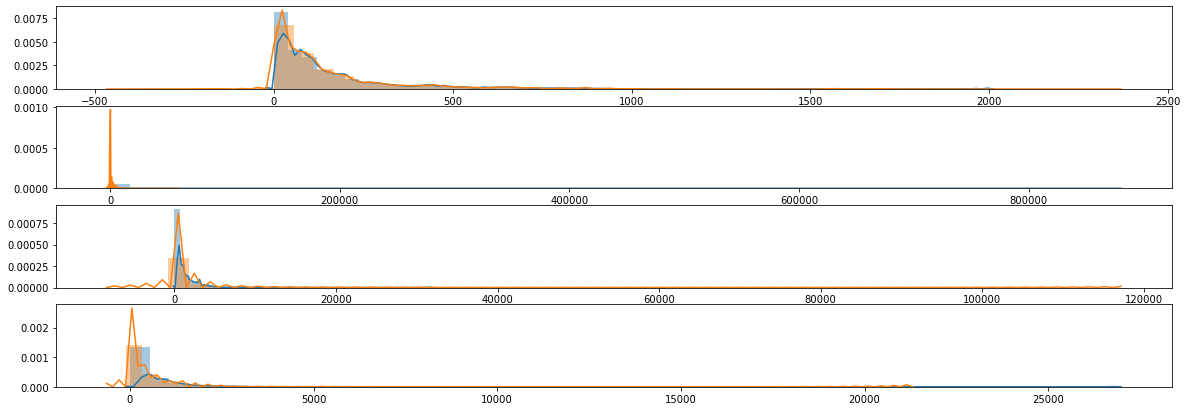

In [217]:
%%time
drop_cols = 'meter_reading_log1p_rollmean_6'
gbm = LGBMRegressor()
fig, ax = plt.subplots(4,1,figsize=(20,7))
for target_meter in range(4):
  _train_df = merged_train_df[merged_train_df.meter_type==target_meter]
  X_train = _train_df[list(set(feature_cols + category_cols) - set(drop_cols))]
  y_train = _train_df['meter_reading'].values
  _test_df = merged_test_df[merged_test_df.meter_type==target_meter]
  X_test = _test_df[list(set(feature_cols + category_cols) - set(drop_cols))]
  y_test = _test_df['meter_reading'].values
  del(_train_df)
  del(_test_df)
  param_dist = {"max_depth": [50],
              "learning_rate" : [0.1],
              "num_leaves": [31],
              "n_estimators": [100],
              }
  tscv = TimeSeriesSplit(n_splits=3)
  lgbm_grid_6 = GridSearchCV(gbm, param_grid=param_dist,cv = tscv, scoring="neg_mean_squared_error", verbose=5)
  lgbm_grid_6.fit(X_train,y_train)
  
  y_train_pred = lgbm_grid_6.predict(X_train)
  lr_mse_train = mean_squared_error(y_train,y_train_pred)
  lr_r2_train = r2_score(y_train,y_train_pred)

  
  y_test_pred = lgbm_grid_6.predict(X_test)
  lr_mse_test = mean_squared_error(y_test,y_test_pred)
  lr_r2_test = r2_score(y_test,y_test_pred)

  lgbm_compare_df.loc[len(lgbm_compare_df.index)] = ['lgbm_grid_6',target_meter,lr_mse_train,lr_mse_test,lr_r2_train,lr_r2_test,lgbm_grid_6.best_params_]

  sns.distplot(y_test,ax=ax[target_meter])
  sns.distplot(y_test_pred,ax=ax[target_meter])

In [218]:
lgbm_compare_df

,lgbm_name,target_meter,mse_train,mse_test,R2-train,R2-test,parameters
0,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",0,3.975602e-02,5.543757e-02,0.986377,0.974872,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
1,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",1,1.559250e-01,4.325241e-01,0.974506,0.939886,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
2,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",2,4.894780e-01,3.952590e-01,0.936970,0.906677,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
3,"GridSearchCV(cv=5, estimator=LGBMRegressor(),\...",3,5.326340e-01,1.146853e+00,0.915576,0.839900,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es..."
4,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,0,3.975602e-02,5.543757e-02,0.986377,0.974872,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
5,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,1,1.802760e-01,4.199406e-01,0.970524,0.941635,"{'learning_rate': 0.05, 'max_depth': 50, 'n_es..."
6,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,2,4.918722e-01,3.997972e-01,0.936662,0.905606,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
7,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,3,5.213427e-01,1.215322e+00,0.917365,0.830342,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
8,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,0,3.782325e-02,5.697374e-02,0.987040,0.974175,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."
9,GridSearchCV(cv=TimeSeriesSplit(max_train_size...,1,2.212132e-01,4.457097e-01,0.963831,0.938053,"{'learning_rate': 0.1, 'max_depth': 50, 'n_est..."


In [229]:
np.log(lgbm_compare_df[lgbm_compare_df.lgbm_name=='lgbm_grid_6'][['mse_train','mse_test']])

,mse_train,mse_test
20,7.975231,6.708006
21,12.259797,18.949637
22,21.756942,12.279440
23,13.960506,12.728503
24,7.975231,6.708006
25,12.259797,18.949637
26,21.756942,12.279440
27,13.960506,12.728503


#### LGBM with RandomizedSearch CV

In [ ]:
%%time
from sklearn  import model_selection

target_meter = 1
X_train,y_train = create_X_y(merged_train_df,target_meter)
X_test,y_test = create_X_y(merged_test_df,target_meter)

lgbm = LGBMRegressor(boosting_type='goss')
param_dist = {"max_depth": np.arange(10,100,20),
              "learning_rate" : np.arange(0.01,0.1,0.02),
              "num_leaves": np.arange(31,150,30),
              "n_estimators": [150],
             }

grid_search = model_selection.RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=5,cv = 5, scoring="neg_mean_squared_error", verbose=5,n_jobs=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] num_leaves=91, n_estimators=150, max_depth=90, learning_rate=0.08999999999999998 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  num_leaves=91, n_estimators=150, max_depth=90, learning_rate=0.08999999999999998, score=-1739206768181906890331881870140548835180544.000, total=  38.7s
[CV] num_leaves=91, n_estimators=150, max_depth=90, learning_rate=0.08999999999999998 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.7s remaining:    0.0s


[CV]  num_leaves=91, n_estimators=150, max_depth=90, learning_rate=0.08999999999999998, score=-12447839653592831282657571646569852174336.000, total=  36.4s
[CV] num_leaves=91, n_estimators=150, max_depth=90, learning_rate=0.08999999999999998 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV]  num_leaves=91, n_estimators=150, max_depth=90, learning_rate=0.08999999999999998, score=-26223427182164889600.000, total=  33.7s
[CV] num_leaves=91, n_estimators=150, max_depth=90, learning_rate=0.08999999999999998 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min remaining:    0.0s


[CV]  num_leaves=91, n_estimators=150, max_depth=90, learning_rate=0.08999999999999998, score=-1649686415503624637513728.000, total=  31.1s
[CV] num_leaves=61, n_estimators=150, max_depth=30, learning_rate=0.049999999999999996 
[CV]  num_leaves=61, n_estimators=150, max_depth=30, learning_rate=0.049999999999999996, score=-9241137476359666144378880.000, total=  33.4s
[CV] num_leaves=61, n_estimators=150, max_depth=30, learning_rate=0.049999999999999996 
[CV]  num_leaves=61, n_estimators=150, max_depth=30, learning_rate=0.049999999999999996, score=-631978383131207.750, total=  33.7s
[CV] num_leaves=61, n_estimators=150, max_depth=30, learning_rate=0.049999999999999996 
[CV]  num_leaves=61, n_estimators=150, max_depth=30, learning_rate=0.049999999999999996, score=-19838537336042932928512.000, total=  32.9s
[CV] num_leaves=61, n_estimators=150, max_depth=30, learning_rate=0.049999999999999996 
[CV]  num_leaves=61, n_estimators=150, max_depth=30, learning_rate=0.049999999999999996, score=-1

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 14.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='goss',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...
                                           subsample_for_bin=200000,
                                           subsample_freq=0),
     

## Final Model

In [208]:
weather_test_df['week'] = weather_test_df['week'].astype(np.int8)

In [209]:
weather_test_df['week'].dtype

dtype('int8')